## About this project
Evaluate how a transformed dataset using bias mitigating algorithms impacts the accuracy and fairness of a trained machine learning model.

## Mitigating Bias in ML utilizing AI Fairness 360

AI Fairness 360 is a toolkit to help examine, report, and mitigate discrimination and bias in machine learning models throughout the AI application lifecycle. It helps address these problems by providing fairness metrics and bias mitigators. 

<a href="https://aif360.mybluemix.net/">AI Fairness 360</a>
## Bias and Machine Learning
A machine learning model makes predictions of an outcome for a particular instance. In this case, given an instance of a loan application, predict if the applicant will be approved or not.
The model makes these predictions based on a training dataset, where many instances (applicants) and actual outcomes 
(loan approved or denied) are provided. This project will use Gender (Male or Female) as the protected group to see if it plays a significant role in the prediction of loan approvals. 


<img align="left" src="Complex_NoProc_V3.jpg">



## The Dataset 
<a href="https://www.kaggle.com/datasets/vipin20/loan-application-data"> Source</a>
<ol><b>
            <li>Loan_ID</li>
            <li>Gender</li>
            <li>Married</li>
            <li>Dependents</li>
            <li>Education</li>    
            <li>Self_Employed</li>
            <li>ApplicantIncome</li>
            <li>CoapplicantIncome</li>
            <li>LoanAmount</li>  
            <li>Loan_Amount_Term</li>
            <li>Credit_History</li>
            <li>Property_Area</li>
            <li>Loan_Status</li>
            <li>Total_Income</li>
            </b>
          </ol>


## Import Statements

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import aif360
from aif360.algorithms import Transformer
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


## Load the dataset

In [2]:
# create a pandas dataframe from the dataset

df = pd.read_csv('df1_loan.csv')
df = df.dropna(how='any', axis=0)


## Loan approval stats

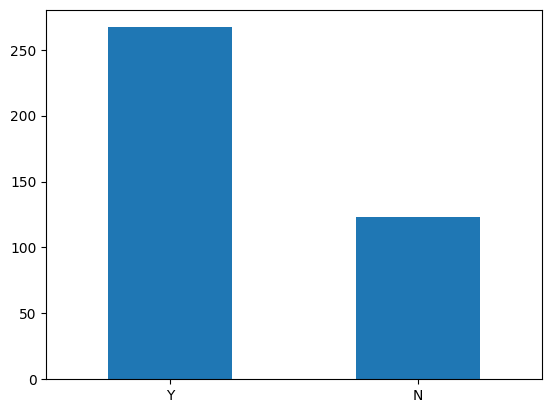

<Figure size 200x200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

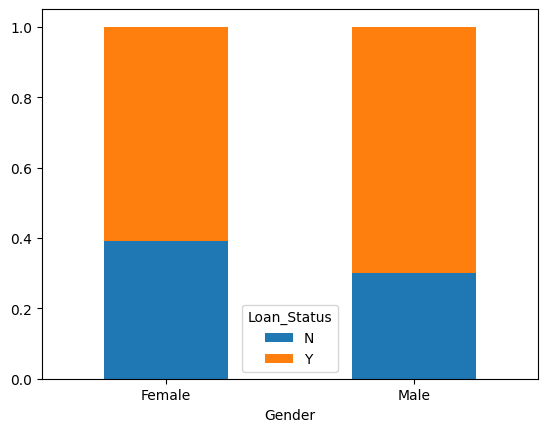

<Figure size 200x200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:

df['Loan_Status'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.figure(figsize=(2,2))
plt.show()
plt.clf()

# normalized

Gender = pd.crosstab(df['Gender'], df['Loan_Status'])
Gender.div(Gender.sum(1), axis=0).plot(kind="bar", stacked = True)
plt.xticks(rotation=0)
plt.figure(figsize=(2,2))
plt.show()

plt.clf()

## Encode the data to binary

In [4]:
df.loc[df.Gender == 'Male', 'Gender'] = 1
df.loc[df.Gender == 'Female', 'Gender'] = 0

# Favorable outcome

df.loc[df.Loan_Status == 'Y', 'Loan_Status'] = 1
df.loc[df.Loan_Status == 'N', 'Loan_Status'] = 0

df = df.drop(columns='Loan_ID', axis=1)

data = ['Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for feature in data:
    onehot = pd.get_dummies(df[feature], prefix=feature)
    df = df.drop(feature, axis=1)
    df = df.join(onehot)

orig_df = df.copy()

binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=['Loan_Status'],
    protected_attribute_names=['Gender'])

## Quantify bias
One technique to quanitfy bias is measure the Disparate impact ratio. Disparate impact compares the percentage of favorable outcomes (approved loan) for a monitored group to the percentage of favorable outcomes for a reference group. We will use Gender as the protected attribute. The favorable outcome is the loan being approved
#### Disparate Impact ratio

<img align="left" src="di_ratio.PNG">




In [5]:
privileged_groups = [{'Gender': 1}] # male
unprivileged_groups = [{'Gender': 0}] # female

### Results

In [6]:
dataset_metric = BinaryLabelDatasetMetric(binaryLabelDataset, unprivileged_groups, privileged_groups)

print('Disparte impact')
print(dataset_metric.disparate_impact())

Disparte impact
0.8684057971014494


A value of 1.0 indicates equality. <br>
A value below 1.0 indicates bias in favor of the privileged group.<br>
A value above 1.0 indicates bias in favor of the unprivileged group.

These results indicate that the privileged group is getting  ~13% more positive outcomes compared to the unprivileged group.

## Mitigate bias by transforming the original dataset

### Disparate impact remover

Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups.


In [7]:
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transformed = di.fit_transform(binaryLabelDataset)

df_transformed = dataset_transformed.convert_to_dataframe()[0]
transformed_data_metric = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups, privileged_groups)

### Results

In [8]:
transformed_data_metric = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups, privileged_groups)
print('Transformed Disparate impact ratio')
print(transformed_data_metric.disparate_impact())

Transformed Disparate impact ratio
0.8684057971014494


The Disparate impact ratio is the same even after transofrming the dataset with the Disparate Impact Remover algorithm. 

### Reweighing
Reweighing is a data preprocessing technique which generates weights for the training examples in each (group, label) combination differently to ensure fairness before classification

In [9]:
RW = Reweighing(privileged_groups, unprivileged_groups)
rw_dataset_transformed = RW.fit_transform(binaryLabelDataset)
rw_df_transformed = rw_dataset_transformed.convert_to_dataframe()[0]

### Results

In [10]:
transformed_data_metric = BinaryLabelDatasetMetric(rw_dataset_transformed, unprivileged_groups, privileged_groups)
print('RW Transformed Disparate Impact Ratio')
print(transformed_data_metric.disparate_impact())

RW Transformed Disparate Impact Ratio
0.9999999999999996


Now there is less than a .1% Disparate impact ratio

## Build a machine learning model using the original dataset

### Logistic Regression

Logistic Regression is used in the analysis of multiple factors influencing a negative/positive outcome, or any other classification where there are only two possible outcomes. 

This type of statistical model is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring. In this case, if the loan was approved or not. The dependent variable is bounded between 0 and 1. 

### Split the original dataset into train and test

In [11]:
y = orig_df['Loan_Status'].astype('int')
x = orig_df.drop(['Loan_Status'], axis=1)

scaler = StandardScaler()
data_std = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)


### Train the model on the original data set

In [12]:
model = make_pipeline(scaler,LogisticRegression(solver='liblinear', class_weight='balanced'))

# Fit the model to the training data
model.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

### Results

In [13]:
print('original accuracy')

from sklearn.metrics import accuracy_score
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))

original accuracy
0.6752136752136753


In [14]:
from sklearn.metrics import classification_report
print('model classification report')
print(classification_report(y_test,predictions))


model classification report
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        37
           1       0.77      0.75      0.76        80

    accuracy                           0.68       117
   macro avg       0.63      0.63      0.63       117
weighted avg       0.68      0.68      0.68       117



In [15]:
x_test['Loan_Predicted'] = predictions

male_df = x_test[x_test['Gender'] == 1]
female_df = x_test[x_test['Gender'] == 0]

unpriviliged_ratio = female_df[female_df['Loan_Predicted'] == 1].shape[0]/x_test[x_test['Gender'] == 0].shape[0]
priviliged_ratio = male_df[male_df['Loan_Predicted'] == 1].shape[0]/x_test[x_test['Gender'] == 1].shape[0]

print("Disparate Impact Ratio") 
print(unpriviliged_ratio / priviliged_ratio)

Disparate Impact Ratio
0.5698529411764706


## Build a machine learning model using the transformed dataset (Disparate impact remover)

### Split the original dataset into train and test

In [16]:
y = df_transformed['Loan_Status'].astype('int')
x = df_transformed.drop(['Loan_Status'], axis=1)

x_trans_train, x_trans_test, y_trans_train, y_trans_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Train the model on the transformed data set

In [17]:
scaler = StandardScaler()
data_std = scaler.fit_transform(x)
model = make_pipeline(scaler,LogisticRegression(solver='liblinear', class_weight='balanced'))
model.fit(x_trans_train, y_trans_train)

trans_predictions = model.predict(x_trans_test)

### Results

In [18]:
print(accuracy_score(y_trans_test, trans_predictions))

0.6794871794871795


In [19]:
print('model classification report')
print(classification_report(y_trans_test,trans_predictions))

model classification report
              precision    recall  f1-score   support

           0       0.45      0.43      0.44        23
           1       0.77      0.78      0.77        55

    accuracy                           0.68        78
   macro avg       0.61      0.61      0.61        78
weighted avg       0.68      0.68      0.68        78



The accuracy actually increased by 1%

In [20]:
x_trans_test['Loan_Predicted'] = trans_predictions

male_df = x_trans_test[x_trans_test['Gender'] == 1]
female_df = x_trans_test[x_trans_test['Gender'] == 0]

unpriviliged_ratio = female_df[female_df['Loan_Predicted'] == 1].shape[0]/x_trans_test[x_trans_test['Gender'] == 0].shape[0]
priviliged_ratio = male_df[male_df['Loan_Predicted'] == 1].shape[0]/x_trans_test[x_trans_test['Gender'] == 1].shape[0]

print("Disparate Impact Ratio") 
print(unpriviliged_ratio / priviliged_ratio)

Disparate Impact Ratio
0.8771241830065359


## Build a machine learning model using the transformed dataset (Reweighing)

### Split the dataset into train and test

In [21]:
y = rw_df_transformed['Loan_Status'].astype('int')
x = rw_df_transformed.drop(['Loan_Status'], axis=1)

x_trans_train, x_trans_test, y_trans_train, y_trans_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Train the model on the Reweighed dataset


In [22]:
scaler = StandardScaler()
data_std = scaler.fit_transform(x)
model = make_pipeline(scaler,LogisticRegression(solver='liblinear', class_weight='balanced'))
model.fit(x_trans_train, y_trans_train)

trans_predictions = model.predict(x_trans_test)

### Results

In [23]:
print(accuracy_score(y_trans_test, trans_predictions))

0.6410256410256411


The accuracy is the same as the original model except this time the dataset has less than .1% bias in favor of the privileged group

In [24]:
print('model classification report')
print(classification_report(y_trans_test,trans_predictions))


model classification report
              precision    recall  f1-score   support

           0       0.38      0.35      0.36        23
           1       0.74      0.76      0.75        55

    accuracy                           0.64        78
   macro avg       0.56      0.56      0.56        78
weighted avg       0.63      0.64      0.64        78



In [25]:
x_trans_test['Loan_Predicted'] = trans_predictions

male_df = x_trans_test[x_trans_test['Gender'] == 1]
female_df = x_trans_test[x_trans_test['Gender'] == 0]

unpriviliged_ratio = female_df[female_df['Loan_Predicted'] == 1].shape[0]/x_trans_test[x_trans_test['Gender'] == 0].shape[0]
priviliged_ratio = male_df[male_df['Loan_Predicted'] == 1].shape[0]/x_trans_test[x_trans_test['Gender'] == 1].shape[0]

print("Disparate Impact Ratio") 
print(unpriviliged_ratio / priviliged_ratio)

Disparate Impact Ratio
0.8580562659846548


## Summary

Initially bias was detected in the original dataset by measuring the disparate impact ratio which resulted in .83 <br>
A value below 1.0 indicates bias in favor of the privileged group


Next two preprocessing bias mitigation techniques were used (Disparate Impact remover and Reweighing) to transform the dataset and evaluate the bias. In this instance only reweighing had a significant impact on mitigating the disparate impact ratio from .83 to .99 

After training a machine learning model on a portion of the original dataset, the predictive bias was amplified from .87 to .57 in favor of the privileged group. 

Next the model was trained on a portion of the transformed dataset using disparate impact remover. When its predictive values were evaluated for bias, it was reduced to .88.

Next the model was trained on the transformed dataset using reweighing and evaluated its predictive values for bias, it was also reduced to significantly .86

Research suggests that predictions made by machine learning models can increase biases present in the training data. These results indicate that by attempting to mitigate biases in training data before building a machine learning model it can reduce the biases in the predictive outcome. 


### Sources

https://aif360.readthedocs.io/en/stable/

https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb

https://towardsdatascience.com/mitigating-bias-in-ai-with-aif360-b4305d1f88a9
